In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mdtraj
import os
import glob
import scipy

In [ ]:
coordinate_files = [
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/cg_Majewski_prior_2024.07.06/6MRR/raw/coordinates.npy",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.07.06_SiLU__wd0_lr2.5en4__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_2024.06.26_400fs_CA_lj_angle_SiLU__wd0_lr2.5en4__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.08.03_constrain_SiLU_cutoff2__wd0_lr2.5en4__smax128__6MRR_*.h5",
"/media/DATA_18_TB_1/daniel_s/cgschnet/Majewski_prior_2024.07.06/sim/sim_Majewski_prior_2024.08.03_constrain_tag_SiLU_cutoff2__wd0_explr1en3_0.85__smax128__6MRR_*.h5",
]

# Select another protein from the same set of models
# coordinate_files = [i.replace("6MRR", "5YM7") for i in coordinate_files]
# coordinate_files = [i.replace("6MRR", "3ID4") for i in coordinate_files]
# coordinate_files = [i.replace("6MRR", "2VQ4") for i in coordinate_files]

def load_trajectories(coordinate_files):
    coordinate_list = []
    label_list = []

    ## Alternate version that merges the wildcards
    for cf in coordinate_files:
        label_list.append(os.path.basename(cf))
        batch_traj = []
        for subtraj in glob.glob(cf):
            if subtraj.endswith("npy"):
                coords = np.load(subtraj)
                # Select with a stride that brings the total down to ~10,000
                if len(coords) > 10000:
                    coords = coords[::(len(coords)//10000)]
                # Convert to NM to match mdtraj coordinates
                coords = coords/10
                psf_path = glob.glob(os.path.join(os.path.dirname(cf),"../processed/*_processed.psf"))[0]
                traj = mdtraj.Trajectory(coords, topology=mdtraj.formats.psf.load_psf(psf_path))
            else:
                traj = mdtraj.load(subtraj)
            batch_traj.append(traj)
        if len(batch_traj) == 0:
            raise RuntimeError(f"{cf} did not match any files")
        coordinate_list.append(mdtraj.join(batch_traj))

    assert len(coordinate_list) == len(label_list)
    return coordinate_list, label_list


coordinate_list, label_list = load_trajectories(coordinate_files)
print(coordinate_list)

[<mdtraj.Trajectory with 10000 frames, 68 atoms, 68 residues, without unitcells at 0x7f5a9c51b150>, <mdtraj.Trajectory with 5000 frames, 68 atoms, 68 residues, without unitcells at 0x7f5a94cadd10>, <mdtraj.Trajectory with 5000 frames, 68 atoms, 68 residues, without unitcells at 0x7f5a94aadd90>, <mdtraj.Trajectory with 5000 frames, 68 atoms, 68 residues, without unitcells at 0x7f5a94aa6d50>, <mdtraj.Trajectory with 5000 frames, 68 atoms, 68 residues, without unitcells at 0x7f5a94a60110>]


/home/md-ml/miniconda3/envs/daniel_s-torchmdnet2/lib/python3.11/site-packages/mdtraj/core/trajectory.py:439: UserWarning: top= kwargs ignored since this file parser does not support it
  warnings.warn('top= kwargs ignored since this file parser does not support it')


In [ ]:
def make_plot_grid(length, row_len=3):
    fig, axes = plt.subplots((length+row_len-1)//row_len, min(row_len, length))
    # Ensure axes is always a 2d array
    if isinstance(axes, plt.Axes):
        axes = np.array([[axes]])
    elif len(axes.shape) == 1:
        axes = axes[np.newaxis, :]
    for i in range(length,len(axes.flat)):
        axes.flat[i].remove()
    fig.set_figheight(6*len(axes))
    fig.set_figwidth(6*len(axes[0]))
    return fig, axes

def calculate_bond_lengths(coordinates):
    # Calculate bond lengths for a single carbon alpha chain (or some other simple linear series of bonds)
    # assert coordinates.n_chains == 1, "Only single chain proteins are supported"
    index_list = []
    for chain in coordinates.top.chains:
        a_idx = [i.index for i in chain.atoms]
        for i in range(len(a_idx) - 1):
            index_list.append(a_idx[i:i+2])
    return mdtraj.compute_distances(coordinates, index_list, periodic=False)

def calculate_bond_angles(coordinates):
    # Calculate angles for a single carbon alpha chain (or some other simple linear series of bonds)
    # assert coordinates.n_chains == 1, "Only single chain proteins are supported"
    index_list = []
    for chain in coordinates.top.chains:
        a_idx = [i.index for i in chain.atoms]
        for i in range(len(a_idx) - 2):
            index_list.append(a_idx[i:i+3])
    return mdtraj.compute_angles(coordinates, index_list, periodic=False)

def calculate_dihedrals(coordinates):
    # Calculate angles for a single carbon alpha chain (or some other simple linear series of bonds)
    # assert coordinates.n_chains == 1, "Only single chain proteins are supported"
    index_list = []
    for chain in coordinates.top.chains:
        a_idx = [i.index for i in chain.atoms]
        for i in range(len(a_idx) - 3):
            index_list.append(a_idx[i:i+4])
    result = mdtraj.compute_dihedrals(coordinates, index_list, periodic=False)
    # result[result<0] += 2*np.pi
    return result

def plot_hist(ax, values, bins=350, hist_range=None, label=None):
    # Plots a histogram with the x axis values set to the bin centers
    hist = np.histogram(values, range=hist_range, bins=bins, density=True)
    ax.plot((hist[1][:-1] + hist[1][1:])/2, hist[0], label=label)

def plot_comparison(ax, values, hist_range=None, labels=None):
    # We could use Freedman Diaconis to get an "optimal" bin width for comparing distributions, however
    # this will crash (out of memory) if the protein exploded because the value range gets too large.
    # Because the numerical comparisons don't seem very helpful yet I've disabled this calculation for now
    # and set the default number of bins to approximately it's average value. - Daniel
    
    # bins = np.histogram_bin_edges(np.concatenate(values).flatten(), bins='fd')
    # if len(bins) > 10000:
    #     raise RuntimeError(f"Excessive number of histogram bins {len(bins) - 1}, simulation probably exploded")
    try:
        bins = np.histogram_bin_edges(np.concatenate(values).flatten(), bins=350)
        if bins[-1] - bins[0] > 100:
            raise ValueError(f"max-min={bins[-1] - bins[0]:.2f}")
    except ValueError as exc:
        ax.text(0.5, 0.50, f"Exploded\n({exc})", transform=ax.transAxes, ha='center', weight="bold", color="red")
        return
        

    histograms = []
    for v in values:
        histograms.append(np.histogram(v, bins=bins, density=True))

    points_x = (bins[:-1] + bins[1:])/2
    bin_widths = (bins[1:] - bins[:-1])

    # Normalize histograms by bin width to get a probability mass function
    # Note this requires density=True above
    histograms = [(h[0]*bin_widths, h[1]) for h in histograms]
        
    for hist, label in zip(histograms, labels):
        ax.plot(points_x, hist[0], label=label)

    if len(histograms) == 2:
        wasserstein = scipy.stats.wasserstein_distance(points_x, points_x, histograms[0][0], histograms[1][0])
        ax.text(0.01, 0.95, f"wasserstein={wasserstein:.6f}", transform=ax.transAxes)
        kl_div = scipy.stats.entropy(histograms[0][0], histograms[1][0])
        ax.text(0.01, 0.90, f"K-L divergence={kl_div:.6f}", transform=ax.transAxes)
        rmse = np.sqrt(np.mean((np.square(histograms[0][0] - histograms[1][0]))))
        ax.text(0.01, 0.85, f"RMSE={rmse:.6f}", transform=ax.transAxes)


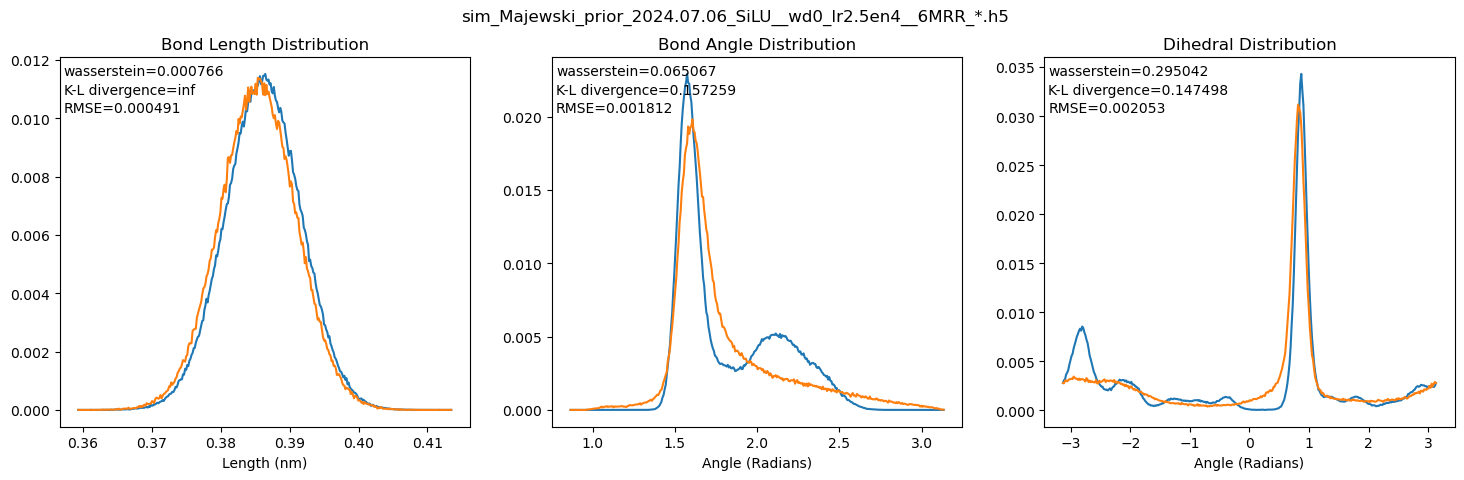

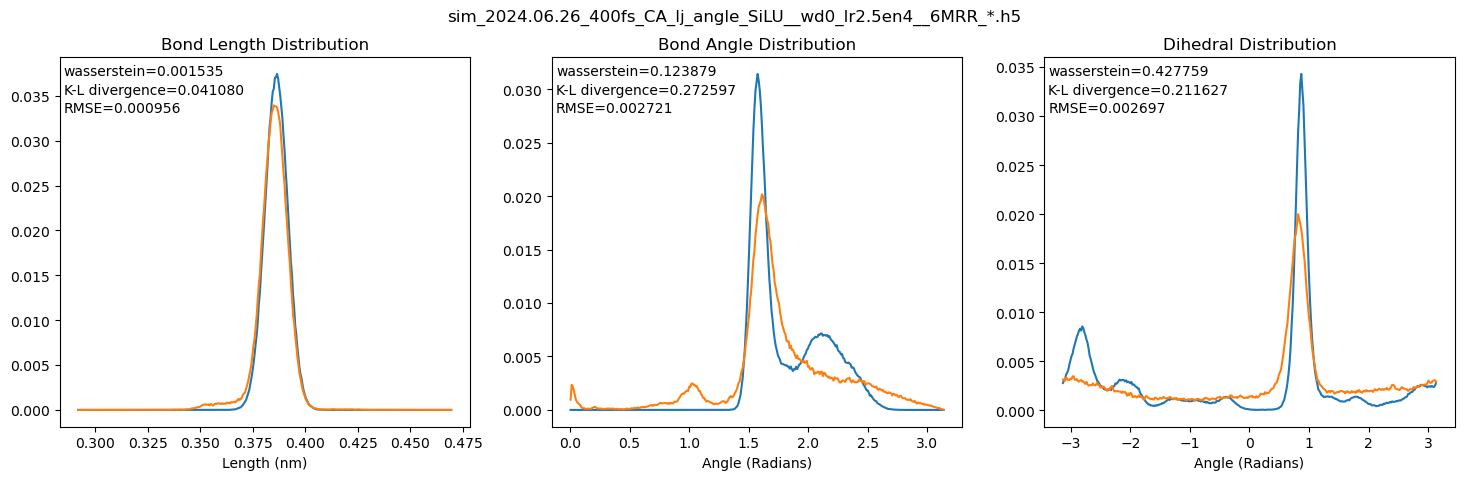

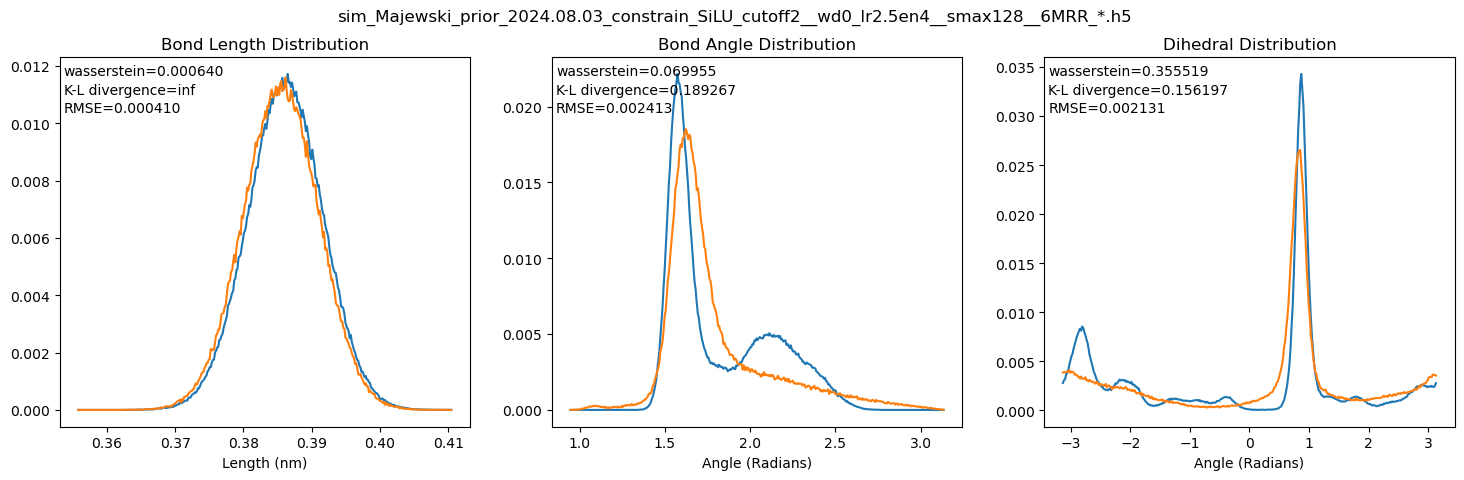

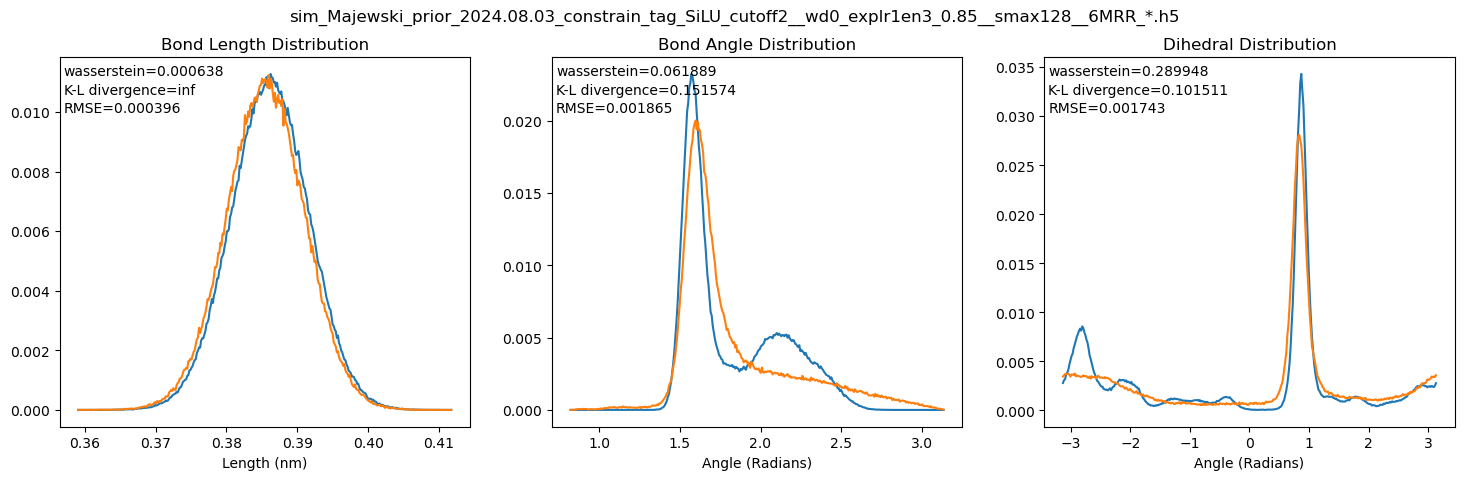

In [4]:

for i in range(1, len(coordinate_list)):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figwidth(18)
    fig.suptitle(label_list[i])

    compare_coordinates = [coordinate_list[0], coordinate_list[i]]

    ax1.set_title("Bond Length Distribution")
    ax1.set_xlabel("Length (nm)")
    plot_comparison(ax1, [calculate_bond_lengths(i) for i in compare_coordinates], labels=label_list)

    ax2.set_title("Bond Angle Distribution")
    ax2.set_xlabel("Angle (Radians)")
    plot_comparison(ax2, [calculate_bond_angles(i) for i in compare_coordinates], labels=label_list)

    ax3.set_title("Dihedral Distribution")
    ax3.set_xlabel("Angle (Radians)")
    plot_comparison(ax3, [calculate_dihedrals(i) for i in compare_coordinates], labels=label_list)



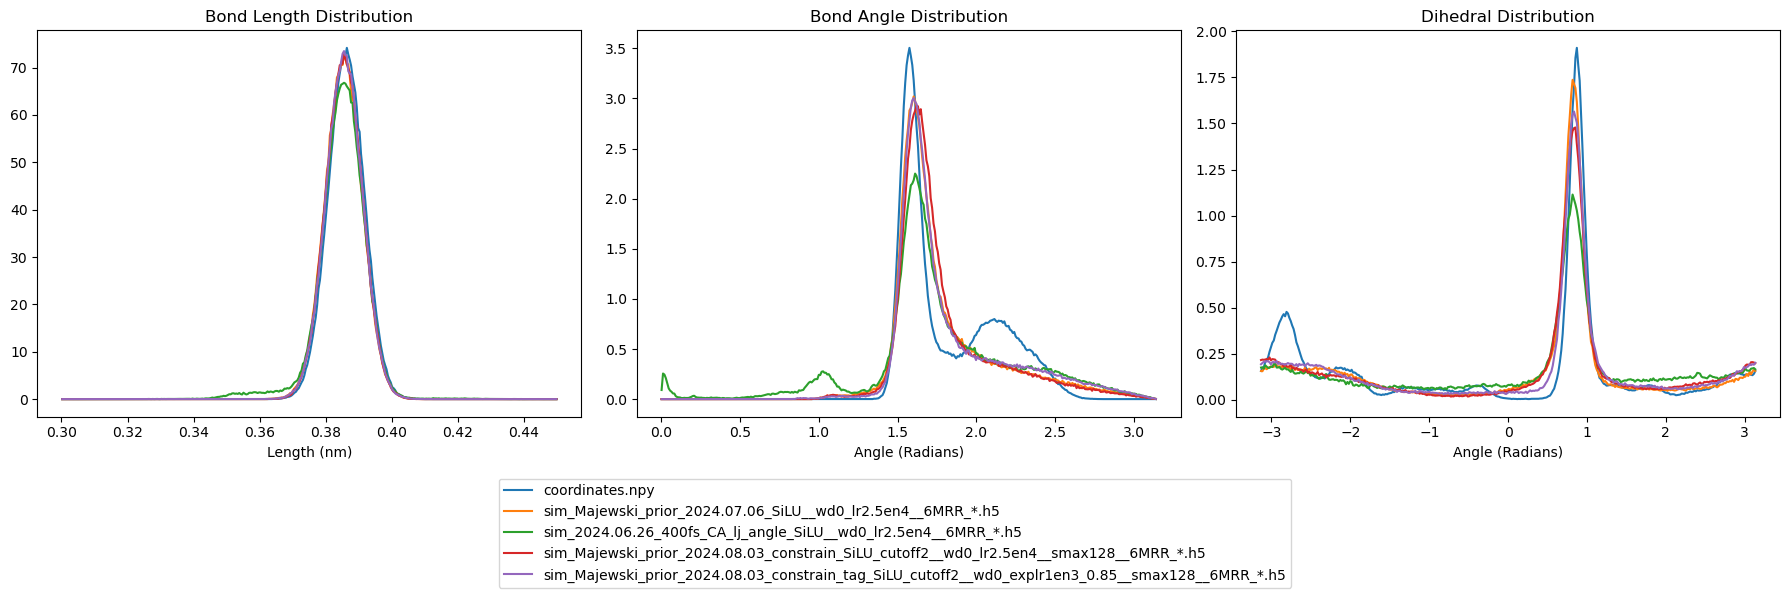

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(18)

ax1.set_title("Bond Length Distribution")
ax1.set_xlabel("Length (nm)")
for c,l in zip(coordinate_list, label_list):
    #FIXME: Make hist range dynamic
    plot_hist(ax1, calculate_bond_lengths(c).flatten(), hist_range=(0.3, 0.45), label=l)

ax2.set_title("Bond Angle Distribution")
ax2.set_xlabel("Angle (Radians)")
for c,l in zip(coordinate_list, label_list):
    plot_hist(ax2, calculate_bond_angles(c).flatten(), hist_range=(0.0, np.pi))

ax3.set_title("Dihedral Distribution")
ax3.set_xlabel("Angle (Radians)")
for c,l in zip(coordinate_list, label_list):
    plot_hist(ax3, calculate_dihedrals(c).flatten(), hist_range=(-np.pi, np.pi))

fig.tight_layout()
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25))

pass

In [6]:
#FIXME: The wildcard heatmaps are a bit deceptive because they're actually several trajectories concatenated
#       together. The loader should record the bounds of each trajectory and then we can draw vertical lines
#       between each one here.

def plot_heatmaps(z_val_list, label_list, title, vmin, vmax, cmap='rainbow'):
    fig, axes = make_plot_grid(len(z_val_list))
    
    for ax, zval, label in zip(axes.flat, z_val_list, label_list):
        ax.set_title(label)
        ax.imshow(zval, cmap=cmap, aspect='auto', interpolation='none', vmin=vmin, vmax=vmax)
        ax.set_yticks(np.arange(len(zval))+0.5, labels=[])
        ax.set_yticks(np.arange(len(zval)), minor=True, labels=np.arange(len(zval)))
        ax.grid(axis='y')
        ax.set_xlabel("Frame")

    fig.suptitle(title)
    fig.set_tight_layout(True)

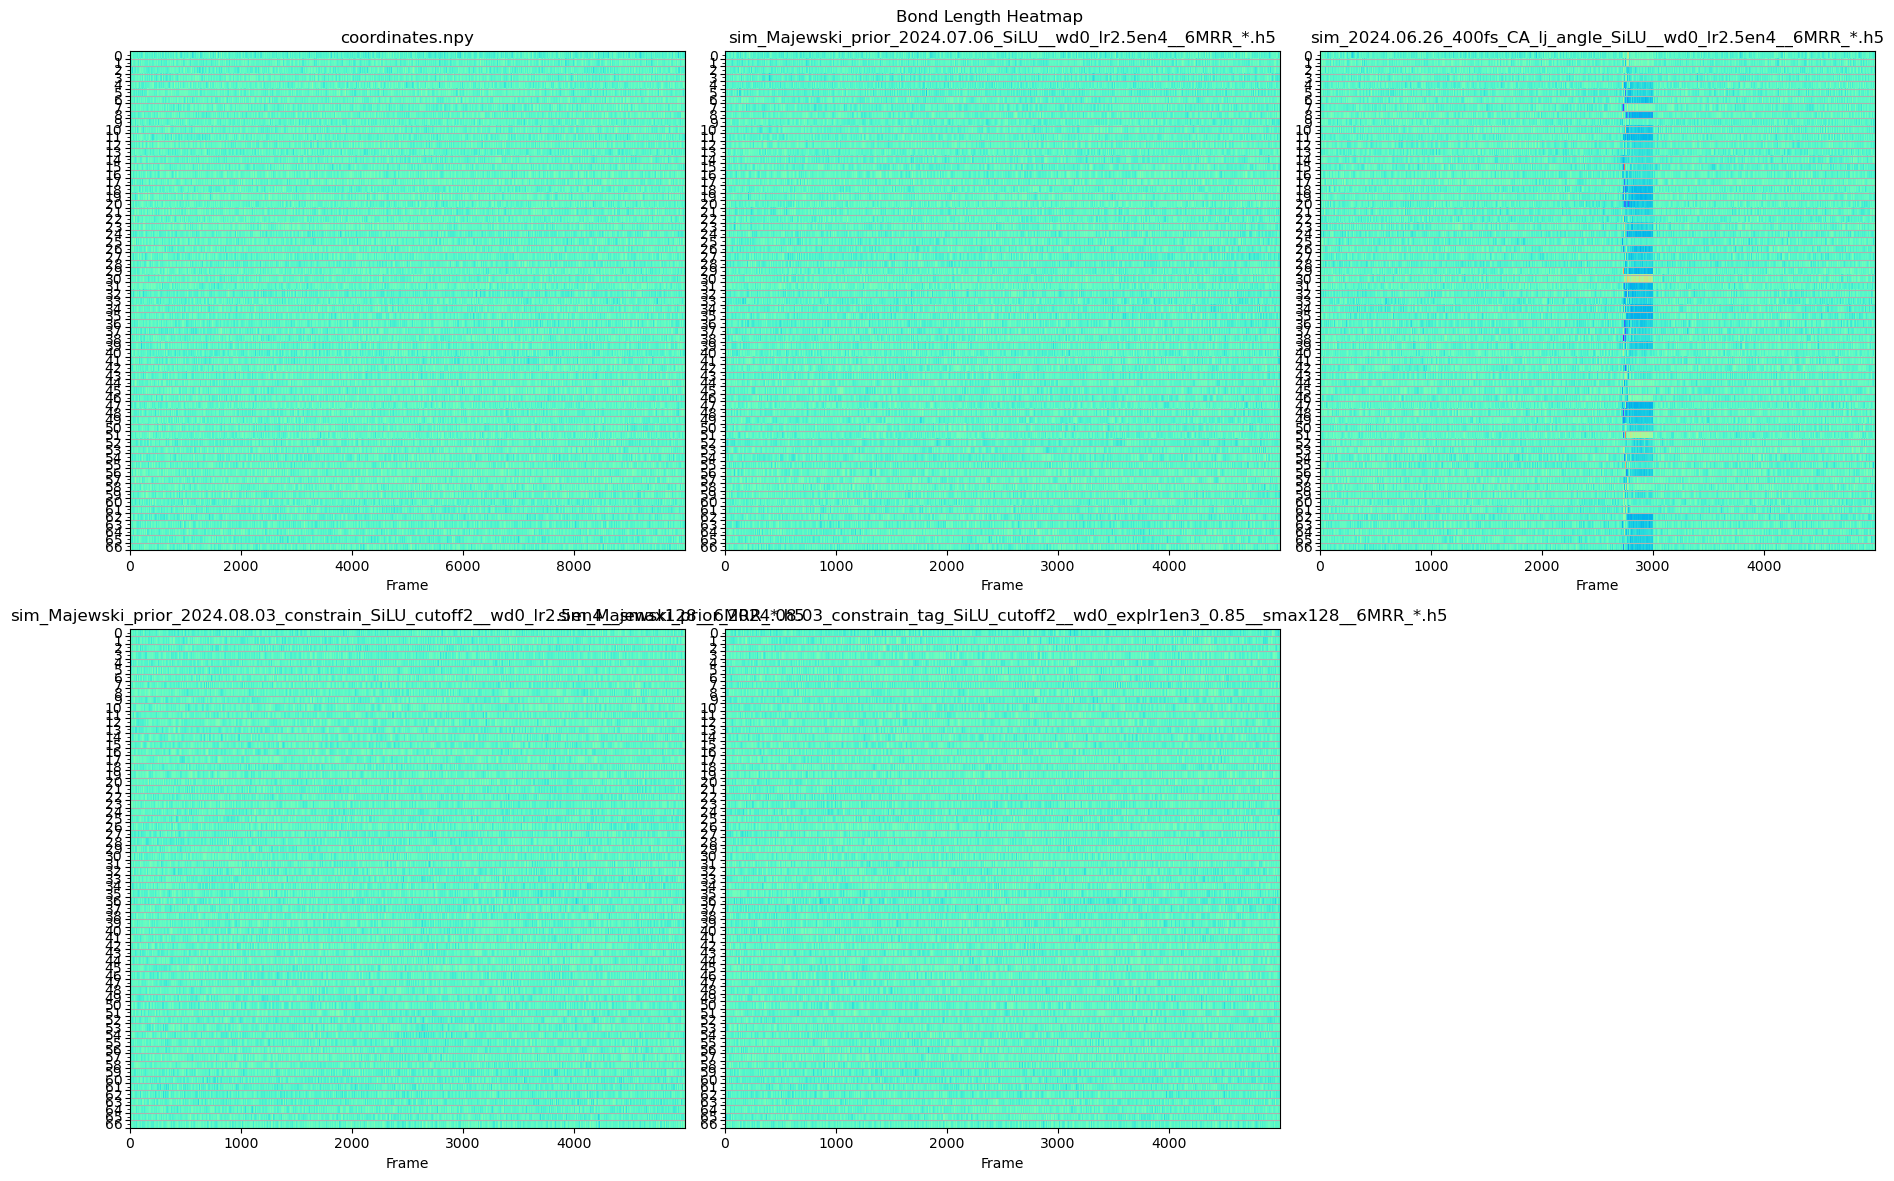

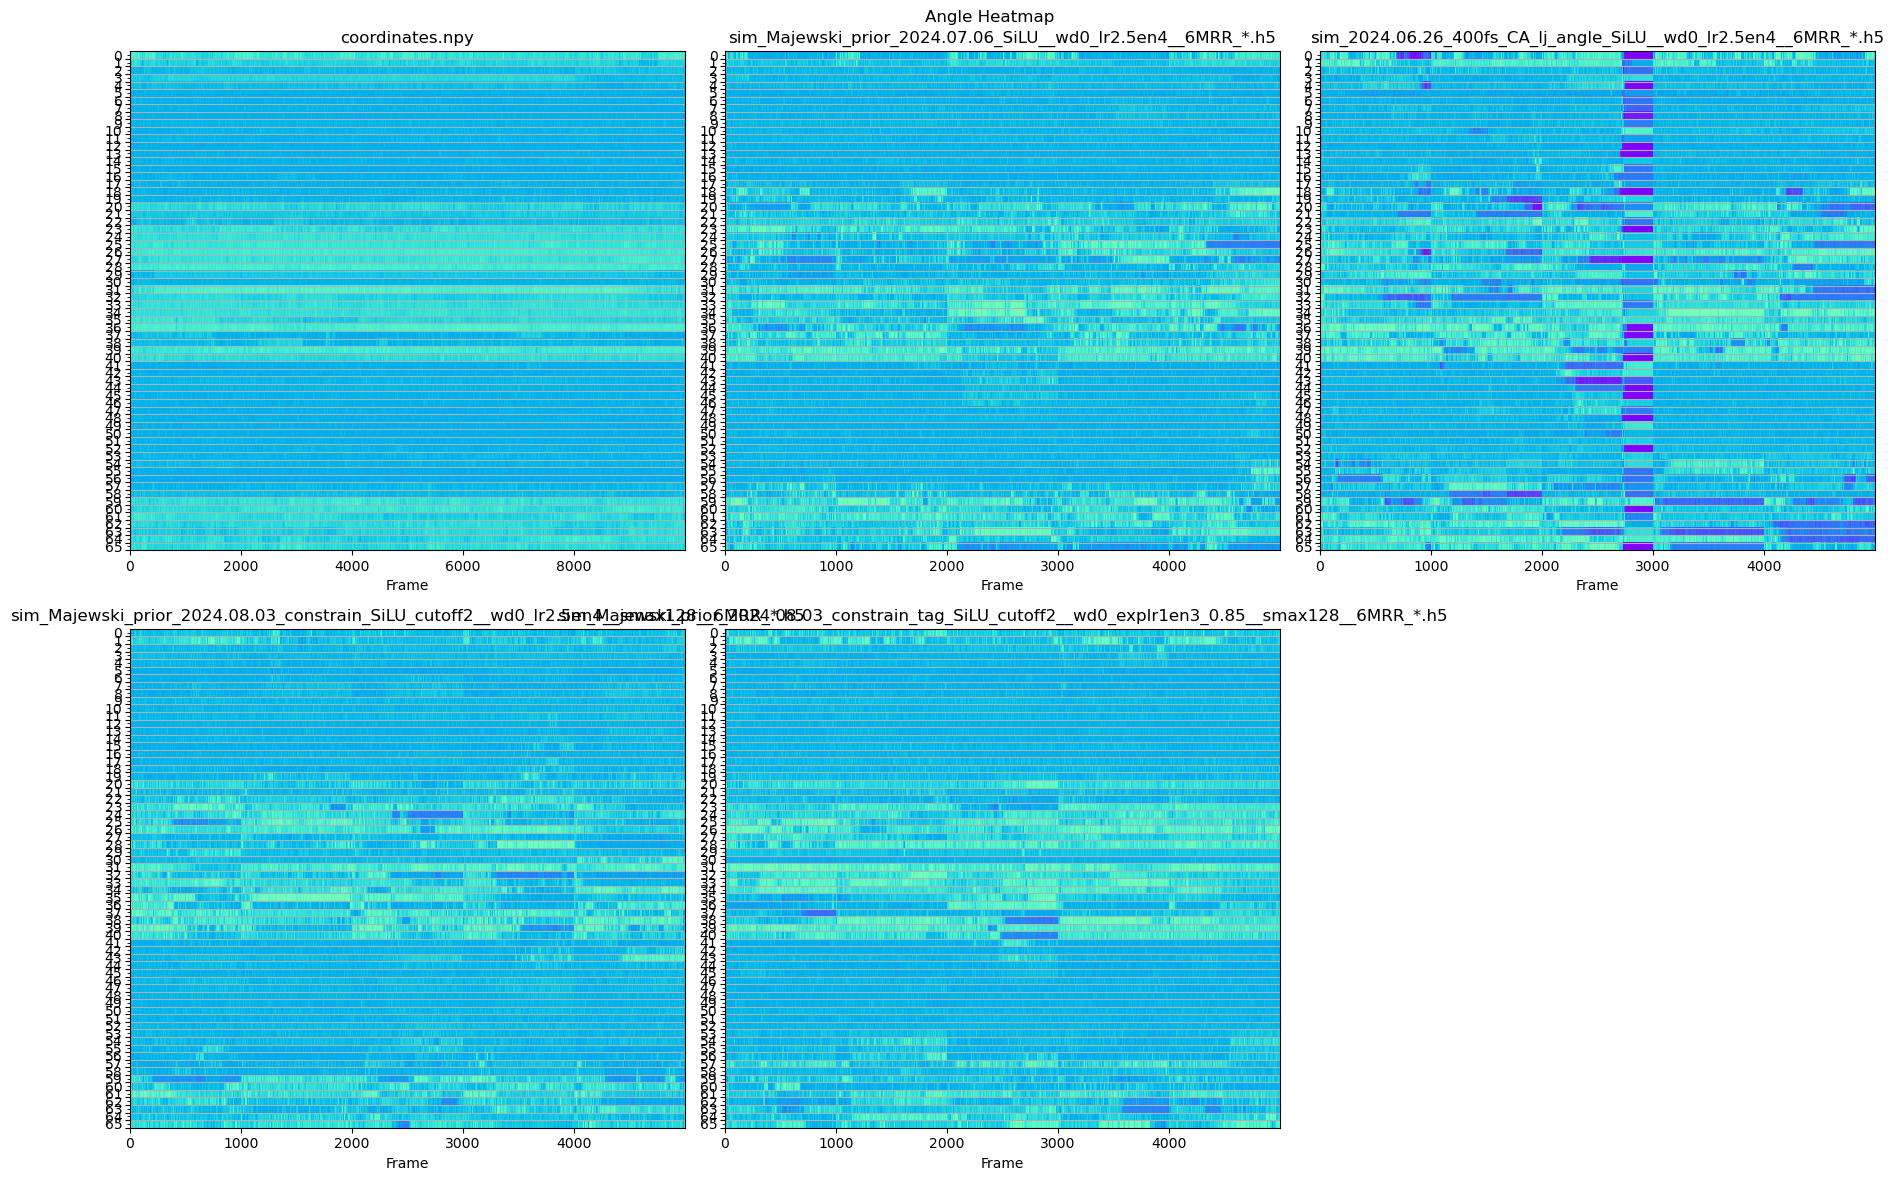

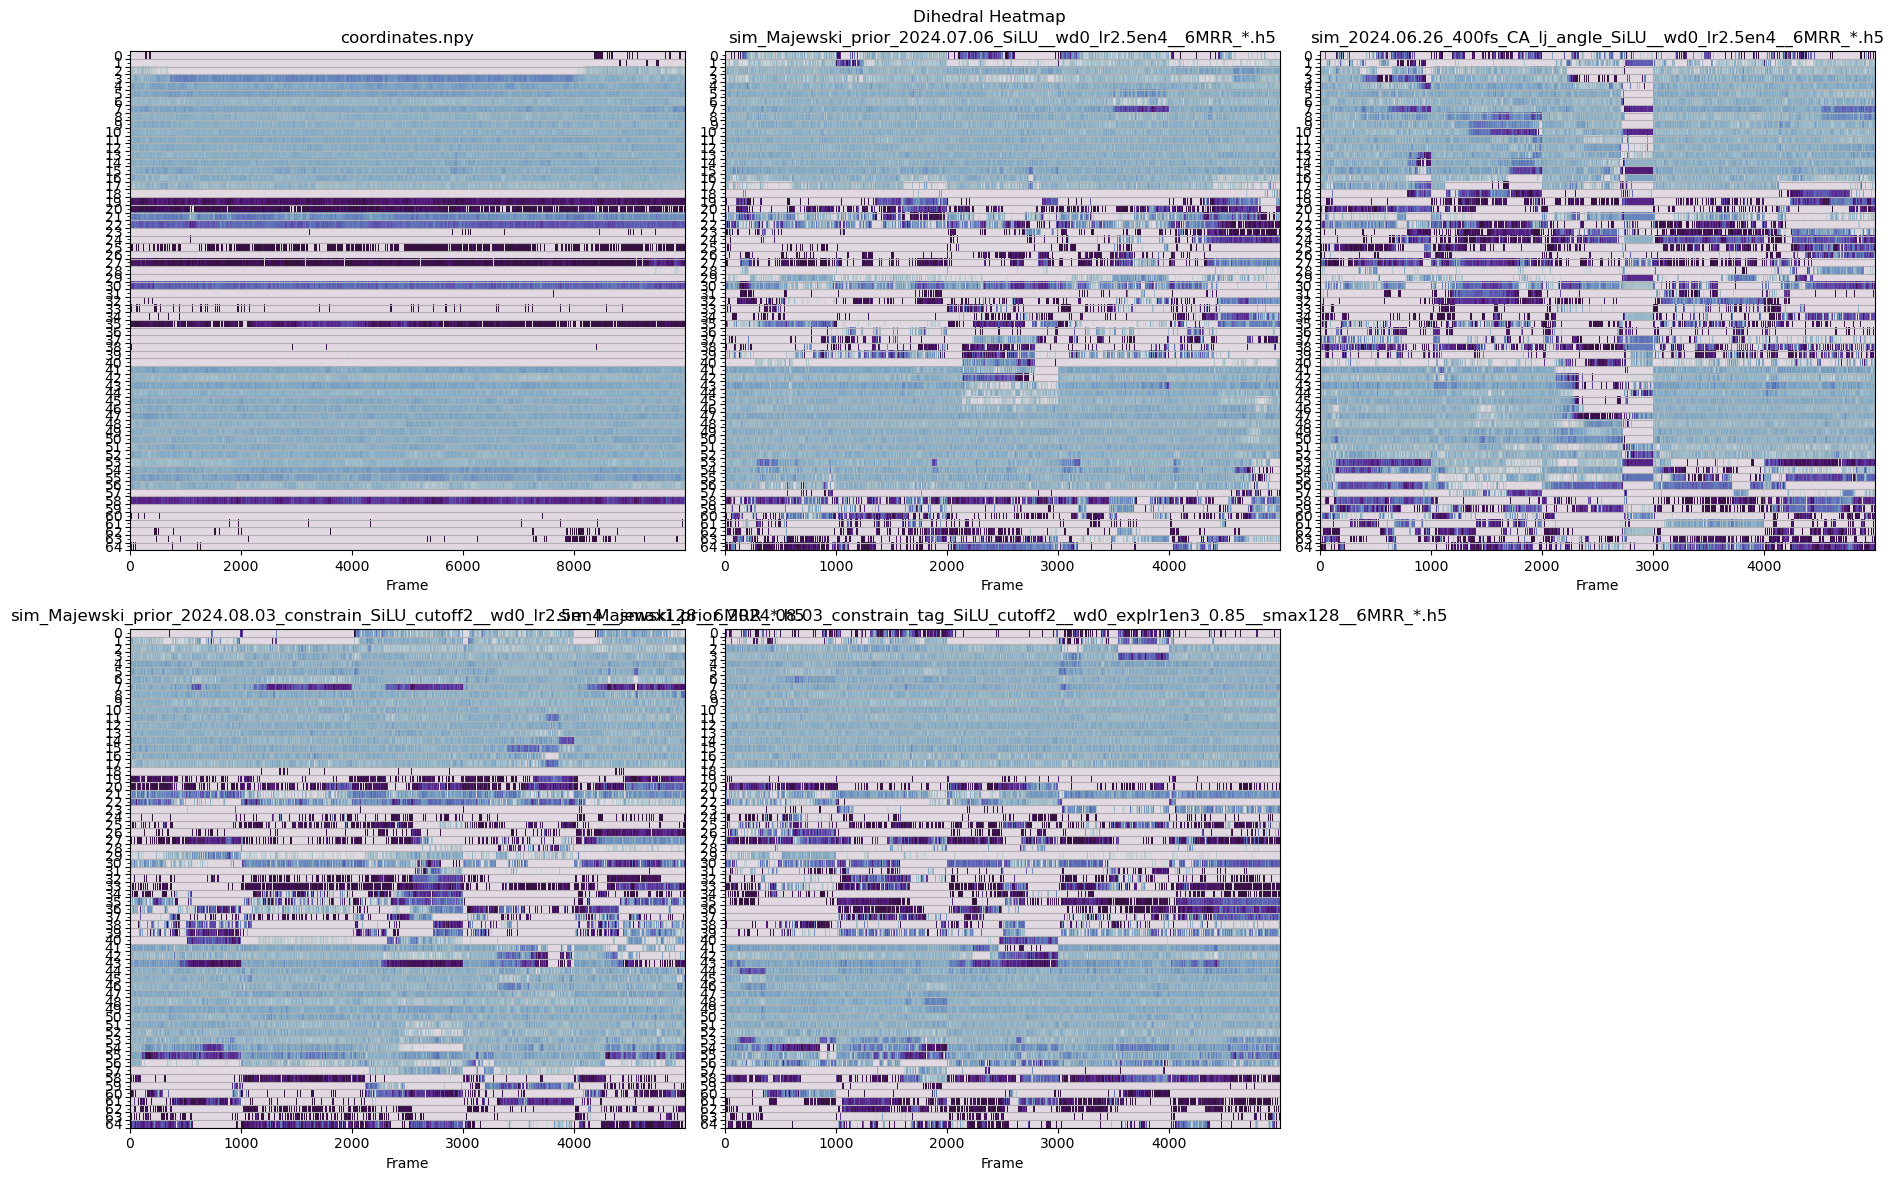

In [7]:
plot_heatmaps([calculate_bond_lengths(c).T for c in coordinate_list],
              label_list, "Bond Length Heatmap", 0.3, 0.5)
# plt.colorbar(label="Length (nm)")

plot_heatmaps([calculate_bond_angles(c).T for c in coordinate_list],
              label_list, "Angle Heatmap", 0, 2*np.pi)
# plt.colorbar(label="Angle (radians)")

plot_heatmaps([calculate_dihedrals(c).T for c in coordinate_list],
              label_list, "Dihedral Heatmap", 0.0, 2*np.pi, cmap='twilight')
# plt.colorbar(label="Angle (radians)")
pass